### Author: Nathaniel Ruhl
### This notebook considers the correlation between the tangent altitude of the 50% transmission point (depends on energy band and certain atmospheric parameters. It demonstrates some of the methods to use when creating an "atmospheric dynamics model" that describes h_50

In [1]:
import sys
sys.path.append("../")  # HCNM2 directory
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
import astropy as ap
from astropy.time import Time

# Libraries used for the navigational problem
from Modules.LocateR0hcNav import LocateR0hcNav
from Modules.FitAtmosphere import FitAtmosphere

# Aditional function to read and do some preliminary processing on RXTE data
from Modules.read_rxte_data import read_rxte_data
from Modules import constants
from Modules.tools import celestial_to_geocentric

from ObservationDictionaries.RXTE.all_dicts import all_dicts

### Calculate h50 and other parameters that may affect atmospheric variation. Note that these key-value pairs are added to the obs_dicts at runtime.

In [2]:
# This function fits and returns the h50 point and latitude of graze point
def RXTE_fit_h50(obs_dict, e_band_ch, h0_ref, orbit_model="rossi"):
    r0_obj = LocateR0hcNav(obs_dict, orbit_model, h0_ref)
    # Identify latitude of graze point
    g = r0_obj.graze_point/np.linalg.norm(r0_obj.graze_point)
    lat = (np.pi/2) - np.arccos(g[2])

    #2) Read in RXTE data for the specified energy band
    rate_data, time_data, normalized_amplitudes, bin_centers_kev, unattenuated_rate, e_band_kev = read_rxte_data(obs_dict, e_band_ch)

    #3) Fit count rate vs h (geocentric tangent altitudes above y0_ref)
    fit_obj = FitAtmosphere(obs_dict, orbit_model, r0_obj,
                rate_data, time_data, unattenuated_rate)

    return fit_obj.c_fit, lat

# This function calculates the acute angle between the source position and the Sun in ECI cooridnates
# This angle represents Time of Day in our model
def calcTOD(obs_dict):
    r_sun_obj = ap.coordinates.get_sun(Time(obs_dict["t_mid_datetime"]))
    ra = np.deg2rad(r_sun_obj.ra).radian
    dec = np.deg2rad(r_sun_obj.dec).radian
    r_sun = celestial_to_geocentric(ra, dec)
    r_source = obs_dict["starECI"]
    tod_angle = np.arccos(np.dot(r_sun, r_source))
    return tod_angle

# This function calculates the acute angle between the Earth and the Sun in the SSB frame
def calcTOY(obs_dict):
    r_sun_obj = ap.coordinates.get_body_barycentric("sun", Time(obs_dict["t_mid_datetime"]))
    r_sun = np.array((r_sun_obj/r_sun_obj.norm()).xyz)
    r_earth_obj = ap.coordinates.get_body_barycentric("earth", Time(obs_dict["t_mid_datetime"]))
    r_earth = np.array((r_earth_obj/r_earth_obj.norm()).xyz)
    toy_angle = np.arccos(np.dot(r_sun, r_earth))
    return toy_angle

h0_ref = 40
R_b = constants.R_EARTH + h0_ref  # radius of the reference "body"
e_band_ch = [7-1, 9]

for obs_dict in all_dicts:
    h50, LAT = RXTE_fit_h50(obs_dict, e_band_ch, h0_ref)
    obs_dict['y50'] = R_b + h50   # km
    obs_dict['TOD'] = calcTOD(obs_dict)
    obs_dict['TOY'] = calcTOY(obs_dict)
    obs_dict['LAT'] = abs(LAT)

# Analysis should also be done on choice of h0_ref... it does change the measured y50 slightly.
# Results for y50 seem to converge when using h0_ref = 40 - 60 km (above 6371 km)

In [3]:
# Construct data matrix
params = ['y50', 'SN', 'TOD'] # 'Ap', 'TOY', 'LAT'   # must already be defined as keys in obs_dict
data = np.zeros((len(all_dicts), len(params)))   # for 3 independent variables
# i'th observation, j'th parameter
for i, obs_dict in enumerate(all_dicts):
    for j in range(len(params)):
        data[i,j] = obs_dict[params[j]]

# save as a pandas data frame
df = pd.DataFrame(data, columns=params)
df

,y50,SN,TOD
0,6482.572694,18.0,2.412085
1,6488.536624,160.0,1.336315
2,6488.576285,62.0,1.409454
3,6491.479021,322.0,0.535804


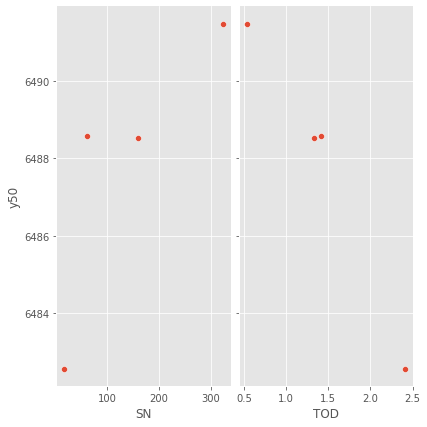

In [4]:
sns.pairplot(df, x_vars=params[1:], y_vars=params[0], height=6, aspect=0.5)

Both of these correlations make sense... "TOD" represents the acute angle between the star (telescope pointing vector) and the sun position as measured in ECI coordinates. SN and f107 are highly correlated and both seem to indicate the inflation/deflation of the atmosphere. Ap and LAT are also highly correlated, but the linear relationship doesn't appear in 4 data points. TOY doesn't seem to be a strong indicator, but we'll have to see with more data points.

<AxesSubplot:>

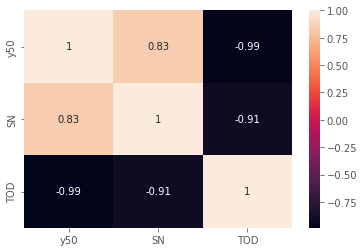

In [5]:
sns.heatmap(df.corr(), annot=True)

## Perform linear regression

In [6]:
from sklearn.linear_model import LinearRegression

x = df[params[1:]]
y50 = df[params[0]]

linModel = LinearRegression()
linModel.fit(x,y50)
print(f"y0 intercept = {linModel.intercept_} km")
print(list(zip(params[1:], linModel.coef_)))

y0 intercept = 6498.368874188102 km
[('SN', -0.010195249864226978), ('TOD', -6.424893023608161)]


## Evaluate model accuracy

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

linModel_pred = linModel.predict(x[params[1:]])
print(f"RMSE = {np.sqrt(mean_squared_error(y50,linModel_pred))}")
print(f"R^2 = {r2_score(y50, linModel_pred)}")

RMSE = 0.22322762245982836
R^2 = 0.9952547777403773
